Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import load_model

Load the Dataset

In [3]:
data= pd.read_csv('CreditCardData_Cleaned.csv')

In [4]:
print("Dataset shape:", data.shape)

Dataset shape: (14997, 39)


In [5]:
data.head()

,Day of Week,Time,Type of Card,Amount,Gender,Age,Fraud,Entry Mode_PIN,Entry Mode_Tap,Type of Transaction_Online,...,Country of Residence_Russia,Country of Residence_USA,Country of Residence_United Kingdom,Bank_Barlcays,Bank_HSBC,Bank_Halifax,Bank_Lloyds,Bank_Metro,Bank_Monzo,Bank_RBS
0,2,19,1,21.0,1,46.1,0,False,False,True,...,False,False,True,False,False,False,True,False,False,False
1,1,0,1,6.0,1,52.0,1,False,False,True,...,False,False,True,False,False,False,False,True,False,False
2,1,9,0,7.0,1,43.9,0,True,False,False,...,False,False,True,False,False,False,False,False,True,False
3,2,20,1,17.0,0,31.5,1,False,False,True,...,False,False,True,False,False,False,False,False,False,False
4,2,11,1,27.0,0,33.8,1,False,False,True,...,False,False,True,True,False,False,False,False,False,False


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14997 entries, 0 to 14996
Data columns (total 39 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Day of Week                            14997 non-null  int64  
 1   Time                                   14997 non-null  int64  
 2   Type of Card                           14997 non-null  int64  
 3   Amount                                 14997 non-null  float64
 4   Gender                                 14997 non-null  int64  
 5   Age                                    14997 non-null  float64
 6   Fraud                                  14997 non-null  int64  
 7   Entry Mode_PIN                         14997 non-null  bool   
 8   Entry Mode_Tap                         14997 non-null  bool   
 9   Type of Transaction_Online             14997 non-null  bool   
 10  Type of Transaction_POS                14997 non-null  bool   
 11  Me

Separate features and target

In [7]:
X = data.drop('Fraud', axis=1)
y = data['Fraud']

Convert non-numeric to numeric CNN needs float/int inputs

In [8]:
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)
    elif X[col].dtype == 'object':
        X[col] = pd.to_numeric(X[col], errors='coerce')

Train-Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Reshape Data for CNN

In [10]:
X_train_cnn = np.expand_dims(X_train.values, axis=2)
X_test_cnn = np.expand_dims(X_test.values, axis=2)

print(f"Train shape for CNN: {X_train_cnn.shape}")
print(f"Test shape for CNN: {X_test_cnn.shape}")

Train shape for CNN: (11997, 38, 1)
Test shape for CNN: (3000, 38, 1)


Build CNN Model

In [11]:
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    Conv1D(filters=32, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])


model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 37, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 36, 32)         │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 18, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,361 (169.38 KB)

 Trainable params: 43,361 (169.38 KB)

 Non-trainable params: 0 (0.00 B)

Train the Model

In [12]:
history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_test_cnn, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7268 - loss: 0.5832 - precision: 0.7186 - recall: 0.6974 - val_accuracy: 0.9340 - val_loss: 0.1871 - val_precision: 0.9053 - val_recall: 0.9632
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9134 - loss: 0.2222 - precision: 0.9059 - recall: 0.9109 - val_accuracy: 0.9413 - val_loss: 0.1582 - val_precision: 0.9179 - val_recall: 0.9639
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9243 - loss: 0.1879 - precision: 0.9139 - recall: 0.9292 - val_accuracy: 0.9473 - val_loss: 0.1372 - val_precision: 0.9433 - val_recall: 0.9472
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9369 - loss: 0.1682 - precision: 0.9264 - recall: 0.9431 - val_accuracy: 0.9527 - val_loss: 0.1278 - val_precision: 0.9320 - val_recall: 0.9722
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9393 - loss: 0.1511 - precision: 0.9232 - recall: 0.9544 - val_accuracy: 0.9560 - val_loss: 0.

Evaluate the Model

In [13]:
y_pred_prob = model.predict(X_test_cnn)
y_pred = (y_pred_prob > 0.5).astype("int32")

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_prob)

print(f" Accuracy:  {acc*100:.2f}%")
print(f" Precision: {prec*100:.2f}%")
print(f" Recall:    {rec*100:.2f}%")
print(f" F1-Score:  {f1*100:.2f}%")
print(f" ROC-AUC:   {roc:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 Accuracy:  96.03%
 Precision: 95.08%
 Recall:    96.73%
 F1-Score:  95.90%
 ROC-AUC:   0.9933


In [14]:
#  Classification Report
print(" Classification Report:")
print(classification_report(y_test, y_pred))

#  Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(" Confusion Matrix:")
print(cm)

 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1561
           1       0.95      0.97      0.96      1439

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000

 Confusion Matrix:
[[1489   72]
 [  47 1392]]


Visualize the Confusion Matrix

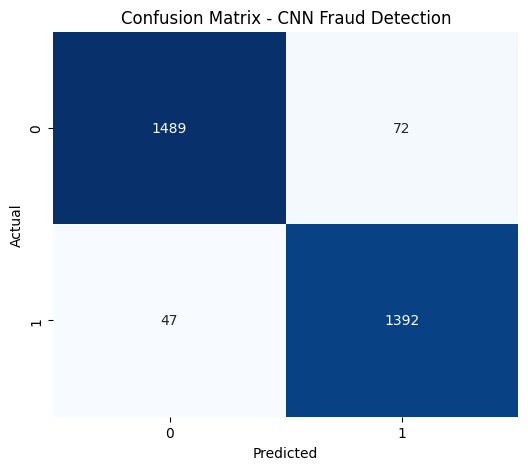

In [15]:

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - CNN Fraud Detection')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Training History Visualization

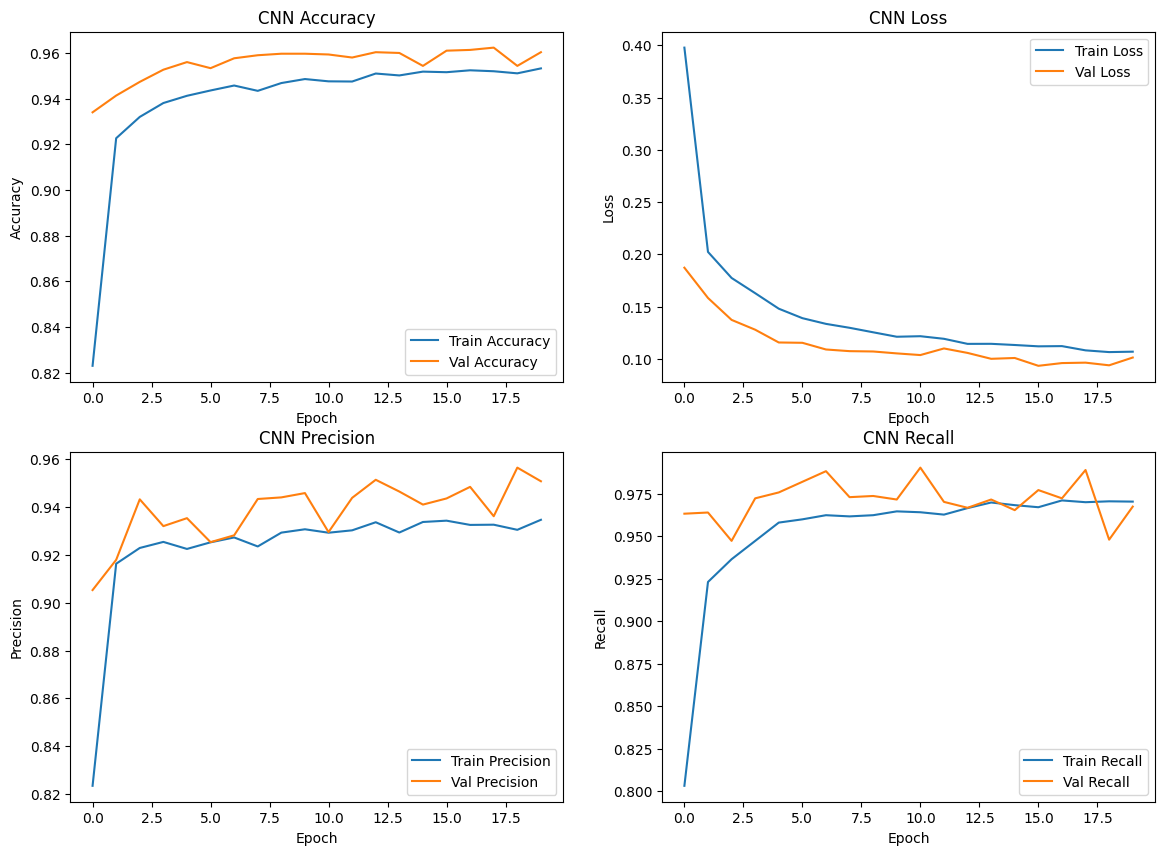

In [16]:
plt.figure(figsize=(14,10))
# Accuracy
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(2,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Precision
plt.subplot(2,2,3)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision')
plt.title('CNN Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()


# Recall
plt.subplot(2,2,4)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')
plt.title('CNN Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.show()

ROC Curve Visualization

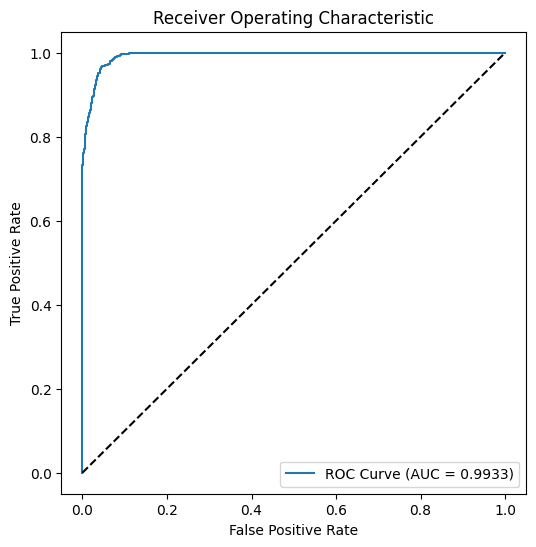

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

In [18]:
model.save("fraud_cnn_model.h5")